In [ ]:
!pip install pytorch-lightning sentence-transformers torchmetrics rich

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import os

os.chdir('/content/drive/MyDrive/NLP Group Project/synthetic-squad-main/src')
os.getcwd()

'/content/drive/MyDrive/NLP Group Project/synthetic-squad-main/src'

# Roberta Baseline

## Task 3

### Prepare the Data

In [4]:
import pandas as pd
from datautils import SynDataModule, SynBatcher


TASK = 3
DPATH = r'/content/drive/MyDrive/NLP Group Project/Texts/punc_data_eval.csv'
MPATH = "distilbert-base-cased"

df = pd.read_csv(DPATH)

label2id = {label: idx for idx, label in enumerate(df['alg'].unique())}
# id2label = {v:k for k,v in label2id.items()}

In [5]:
batcher = SynBatcher(tnkzr_path=MPATH)
eval_dm = SynDataModule(data_path=DPATH, task='aa', label2id=label2id, batcher=batcher, srcs_to_keep=['reddit']) #srcs_to_keep=['reddit'], without this line it gives you aa paper data by default

### Prepare the model

In [ ]:
from modelling import SequenceClassification
from pytorch_lightning.callbacks import(
    EarlyStopping,
    ModelCheckpoint,
    RichModelSummary
)

SAVE_PATH = "/content/drive/MyDrive/NLP Group Project/models/task3/distilbert-base-cased"

# model = SequenceClassification(MPATH, num_labels=len(label2id))
# print("Loaded fresh model")

model = SequenceClassification.load_from_checkpoint("/content/drive/MyDrive/NLP Group Project/synthetic-squad-main/models/task3/distilbert-base-cased/task-3-epoch=1-val_loss=0.18.ckpt")

checkpoint_callback = ModelCheckpoint(
    SAVE_PATH,
    filename=f'task-{TASK}-{{epoch}}-{{val_loss:.2f}}',
    monitor='val_loss',
    save_weights_only=True,
)
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4, patience=8,
    verbose=False,
    mode="min"
)

### Generate model predictions

In [7]:
from pytorch_lightning import Trainer, seed_everything

seed_everything(42, workers=True)

trainer = Trainer(
    max_epochs=-1,
    deterministic=True,
    accumulate_grad_batches=4,
    callbacks=[checkpoint_callback, early_stop_callback, RichModelSummary()],
    accelerator='gpu',
    log_every_n_steps=16
)

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [8]:
trainer.test(model, eval_dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/data.py:103: UserWarning: Total length of `DataLoader` across ranks is zero. Please make sure this was your intention.
  rank_zero_warn(


[]

In [9]:
batcher = SynBatcher(tnkzr_path=MPATH, has_targets=False)
eval_dm = SynDataModule(data_path=DPATH, task='aa', label2id=label2id, batcher=batcher)

In [10]:
import numpy as np

In [ ]:
preds = trainer.predict(model,eval_dm)

In [ ]:
print(preds)

In [14]:
# import numpy as np

indices = [i[0].reshape(len(i[0]), 1) for i in preds]
pred_labels = [i[1].reshape(len(i[1]), 1) for i in preds]

indices = np.vstack(indices)
pred_labels = np.vstack(pred_labels)

pred_data = np.hstack((indices, pred_labels))

In [15]:
df_pred = pd.DataFrame(pred_data)

In [ ]:
# print(df_pred)

In [ ]:
# print(df_pred[1])

In [ ]:
# print(label2id)

In [16]:
filtered_df = df[df['src']=='aa_paper']
temp=[]
c=0
for index,rows in filtered_df.iterrows():
  temp.append([c,label2id[rows['alg']]])
  c+=1
  # print(rows['alg'])
temp_df = pd.DataFrame(temp,columns=['0','1'])
print(temp_df)

         0  1
0        0  0
1        1  1
2        2  2
3        3  3
4        4  2
...    ... ..
1168  1168  8
1169  1169  1
1170  1170  6
1171  1171  8
1172  1172  2

[1173 rows x 2 columns]


[[  0   0   0   0   0   0   0   0   0   0 107]
 [  0   0   0   0   0 107   0   0   0   0   0]
 [  0   0 106   0   0   0   0   0   0   0   0]
 [103   0   0   2   0   0   2   0   0   0   0]
 [  0 105   0   0   1   0   0   0   0   0   0]
 [  0   3   0   1   0   0   0   0   0 103   0]
 [  2   0   0  86   0   0  19   0   0   0   0]
 [  0   0   0   0   0   0   0 107   0   0   0]
 [  0   0   0   0   0   0   0   0 106   0   0]
 [  9   0   0  66   0   0  31   0   0   0   0]
 [  0   0   0   0 107   0   0   0   0   0   0]]


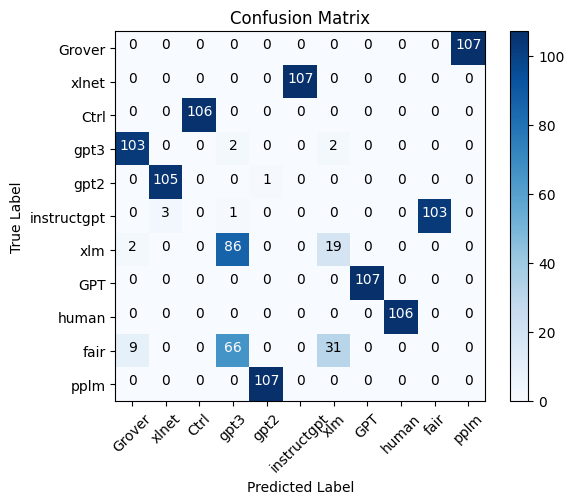

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# example ground truth and predictions
y_true = temp_df['1'].to_list()
y_pred = df_pred[1].to_list()

# create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# print the confusion matrix
print(cm)

# plot the confusion matrix
classes = ['Grover', 'xlnet', 'Ctrl', 'gpt3', 'gpt2', 'instructgpt', 'xlm', 'GPT', 'human', 'fair', 'pplm']
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Task 2

### Prepare the Data

In [17]:
TASK = 2

label2id = {
    'human': 0,
    'machine': 1 
}

In [18]:
batcher = SynBatcher(tnkzr_path=MPATH)
eval_dm = SynDataModule(data_path=DPATH, task='hvm', label2id=label2id, batcher=batcher)

### Prepare the model

In [19]:
SAVE_PATH = "/content/drive/MyDrive/NLP Group Project/models/task2/distilbert-base-cased"

# model = SequenceClassification(MPATH, num_labels=len(label2id))
# print("Loaded fresh model")
model = SequenceClassification.load_from_checkpoint("/content/drive/MyDrive/NLP Group Project/synthetic-squad-main/models/task2/distilbert-base-cased/task-2-epoch=1-val_loss=0.02.ckpt")

checkpoint_callback = ModelCheckpoint(
    SAVE_PATH,
    filename=f'task-{TASK}-{{epoch}}-{{val_loss:.2f}}',
    monitor='val_loss',
    save_weights_only=True,
)
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4, patience=8,
    verbose=False,
    mode="min"
)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bia

### Train the model

In [20]:
#This looks the same as the first trainer

trainer = Trainer(
    max_epochs=-1,
    deterministic=True,
    accumulate_grad_batches=4,
    callbacks=[checkpoint_callback, early_stop_callback, RichModelSummary()],
    accelerator='gpu',
    log_every_n_steps=16
)

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [21]:
trainer.test(model, eval_dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric         ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ test_granular_f1_score_Ctrl │     0.6868618726730347      │
│ test_granular_f1_score_GPT  │     0.9942893385887146      │
│          val_loss           │     0.02909385971724987     │
│     val_macro_f1_score      │      0.840575635433197      │
│    val_overall_f1_score     │     0.9897698163986206      │
└─────────────────────────────┴─────────────────────────────┘

[{'val_loss': 0.02909385971724987,
  'val_overall_f1_score': 0.9897698163986206,
  'val_macro_f1_score': 0.840575635433197,
  'test_granular_f1_score_Ctrl': 0.6868618726730347,
  'test_granular_f1_score_GPT': 0.9942893385887146}]